In [113]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [114]:
EMBEDDING_DIM = 50
MAX_LENGTH = 32
TRAINING_SPLIT = 0.9
NUM_BATCHES = 128

In [115]:
data_path = "./augmented_dataset.csv"
df = pd.read_csv(data_path)
df.head()

,text,label
0,Warner Music Group,Entertainment
1,night essence,Personal Care
2,peel-off mask,Personal Care
3,utensils,Housing
4,rollers,Housing


In [116]:
label_encoder = LabelEncoder()

# 3. Ubah kolom 'Label' dari teks ke angka
df['Label_Encoded'] = label_encoder.fit_transform(df['label'])


# 4. Lihat hasilnya
print(df)

# 5. (Opsional) Lihat mapping antara label teks dan angka
print("Mapping Label Teks ke Angka:")

                    text          label  Label_Encoded
0     Warner Music Group  Entertainment              1
1          night essence  Personal Care              6
2          peel-off mask  Personal Care              6
3               utensils        Housing              3
4                rollers        Housing              3
...                  ...            ...            ...
3189      safety goggles        Housing              3
3190               razor        Housing              3
3191  disinfectant wipes        Housing              3
3192           Frito-Lay           Food              2
3193        paper towels        Housing              3

[3194 rows x 3 columns]
Mapping Label Teks ke Angka:


In [117]:
labels = df['Label_Encoded'].to_numpy()
# Since the original dataset does not provide headers,
# you need to index the columns by their index.
# df has only 2 columns, indexed by 0 and 1.
# Assuming the text data is in the second column (index 1):
sentences = df['text'].to_numpy()

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

# Get the first 5 elements of the dataset
examples = list(dataset.take(5))

print(f"dataset contains {len(dataset)} examples\n")

print(f"Text of second example look like this: {examples[1][0].numpy().decode('utf-8')}\n")
print(f"Labels of first 5 examples look like this: {[x[1].numpy() for x in examples]}")

dataset contains 3194 examples

Text of second example look like this: night essence

Labels of first 5 examples look like this: [1, 6, 6, 3, 3]


In [118]:
# GRADED FUNCTION: train_val_datasets

def train_val_datasets(dataset):
    """
    Splits the dataset into training and validation sets, after shuffling it.

    Args:
        dataset (tf.data.Dataset): Tensorflow dataset with elements as (sentence, label)

    Returns:
        (tf.data.Dataset, tf.data.Dataset): tuple containing the train and validation datasets
    """
    ### START CODE HERE ###

    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(dataset) * TRAINING_SPLIT)

    # Split the sentences and labels into train/validation splits
    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size)

    # Turn the dataset into a batched dataset with num_batches batches
    train_dataset = train_dataset.batch(NUM_BATCHES)
    validation_dataset = validation_dataset.batch(NUM_BATCHES)

    ### END CODE HERE ###

    return train_dataset, validation_dataset

In [119]:
# Create the train and validation datasets
train_dataset, validation_dataset = train_val_datasets(dataset)

print(f"There are {len(train_dataset)} batches for a total of {NUM_BATCHES*len(train_dataset)} elements for training.\n")
print(f"There are {len(validation_dataset)} batches for a total of {NUM_BATCHES*len(validation_dataset)} elements for validation.\n")

There are 23 batches for a total of 2944 elements for training.

There are 3 batches for a total of 384 elements for validation.



In [120]:
# GRADED FUNCTION: fit_vectorizer

def fit_vectorizer(dataset):
    """
    Adapts the TextVectorization layer on the training sentences

    Args:
        dataset (tf.data.Dataset): Tensorflow dataset with training sentences.

    Returns:
        tf.keras.layers.TextVectorization: an instance of the TextVectorization class adapted to the training sentences.
    """

    ### START CODE HERE ###

    # Instantiate the TextVectorization class, defining the necessary arguments alongside their corresponding values
    vectorizer = tf.keras.layers.TextVectorization(
        output_sequence_length=MAX_LENGTH,  # Desired length of output sequences
    )

    # Fit the tokenizer to the training sentences
    vectorizer.adapt(dataset)

    ### END CODE HERE ###

    return vectorizer

In [121]:
# Get only the texts out of the dataset
text_only_dataset = train_dataset.map(lambda text, label: text)

# Adapt the vectorizer to the training sentences
vectorizer = fit_vectorizer(text_only_dataset)

# Check size of vocabulary
vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 1330 words



In [122]:
# Apply vectorization to train and val datasets
train_dataset_vectorized = train_dataset.map(lambda x,y: (vectorizer(x), y))
validation_dataset_vectorized = validation_dataset.map(lambda x,y: (vectorizer(x), y))

In [123]:
# Define path to file containing the embeddings
glove_file = './glove.6B.50d.txt'

# Initialize an empty embeddings index dictionary
glove_embeddings = {}

# Read file and fill glove_embeddings with its contents
with open(glove_file) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coefs

In [124]:
test_word = 'tofu'

test_vector = glove_embeddings[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word tofu looks like this:

[ 0.20942  -0.98482  -1.2391    0.40805   0.40512   0.39992   0.39522
 -0.24839  -0.24858   0.80005   0.086777  0.15108   1.1969    0.64186
  0.24014   0.31678   0.26551   0.21263   0.584    -0.18068   0.76082
 -0.59783   1.3591    0.4671   -0.63289   0.34119  -0.026011  0.80676
  0.76717  -1.0371    0.43321  -0.41427  -0.017847  1.4874   -0.70328
 -0.04138  -0.70141   1.2587    0.97321  -0.19749   0.83928  -0.062772
  0.15655   0.35019   1.6126    0.42649   0.33556   0.03666  -0.32958
  0.66026 ]


In [125]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (50,)


In [126]:
# Create a word index dictionary
word_index = {x:i for i,x in enumerate(vectorizer.get_vocabulary())}

print(f"The word tofu is encoded as: {word_index['tofu']}")

The word tofu is encoded as: 484


In [127]:
# Initialize an empty numpy array with the appropriate size
embeddings_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for
# each word exists within GloVe's representations, save it in the embeddings_matrix array
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [128]:
test_word = 'tofu'

test_word_id = word_index[test_word]

test_vector_tofu = glove_embeddings[test_word]

test_embedding_tofu = embeddings_matrix[test_word_id]

both_equal = np.allclose(test_vector_tofu,test_embedding_tofu)

print(f"word: {test_word}, index: {test_word_id}\n\nEmbedding is equal to column {test_word_id} in the embeddings_matrix: {both_equal}")

word: tofu, index: 484

Embedding is equal to column 484 in the embeddings_matrix: True


In [129]:
def create_model(vocab_size, embedding_dim, embedding_matrix):
    """
    Creates a text classification model.

    Args:
        vocab_size (int): Size of the vocabulary.
        embedding_dim (int): Dimension of the word embeddings.
        embedding_matrix (np.ndarray): Pre-trained embedding matrix.

    Returns:
        tf.keras.Model: The compiled text classification model.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size,
                                  embedding_dim,
                                  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                  trainable=False, # Keep the embeddings fixed
                                  mask_zero=True), # Use masking to handle variable sequence lengths
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # Use a bidirectional LSTM for better context understanding
        tf.keras.layers.Dense(64, activation='relu'), # Add a dense layer for feature extraction
        tf.keras.layers.Dense(10, activation='softmax') # Output layer with softmax for multi-class classification
    ])

    # Compile the model with an appropriate loss function and optimizer
    model.compile(loss='sparse_categorical_crossentropy', # Use categorical_crossentropy for multi-class problems
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [130]:
model = create_model(vocab_size, EMBEDDING_DIM, embeddings_matrix)

In [131]:
# Take an example batch of data
example_batch = train_dataset_vectorized.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (128, 10)


In [132]:
# Train the model and save the training history
history = model.fit(
	train_dataset_vectorized,
	epochs=20,
	validation_data=validation_dataset_vectorized
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.2783 - loss: 2.1864 - val_accuracy: 0.5250 - val_loss: 1.7044
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.6097 - loss: 1.5136 - val_accuracy: 0.6969 - val_loss: 1.1029
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.7073 - loss: 1.0027 - val_accuracy: 0.7844 - val_loss: 0.8392
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.7830 - loss: 0.7733 - val_accuracy: 0.8094 - val_loss: 0.7112
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.8176 - loss: 0.6476 - val_accuracy: 0.8219 - val_loss: 0.6320
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8475 - loss: 0.5581 - val_accuracy: 0.8438 - val_loss: 0.5746
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.8690 - loss: 0.4882 - val_accuracy: 0.8531 - val_loss: 0.5268
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.8802 - loss: 0.4311 - val_accuracy: 0.8562 -

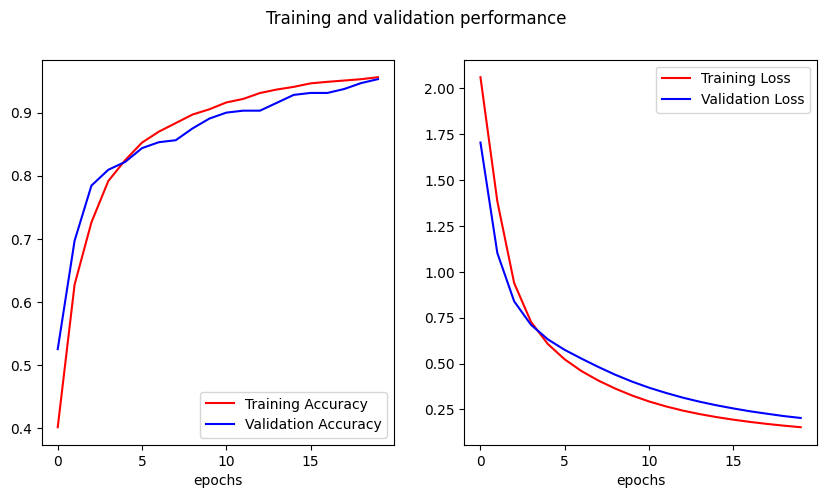

In [133]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation performance')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')